## Objective: Exploring and visualizing the metadata from the [EPIC dataset](http://epic.gs.washington.edu/)
* The dataset contains lots of time series data on the embryogenesis of the C.elegans worm. 
* We'll be plotting and visualizing the movement of various cells withon the embryo with time. 

The visualiszation would compare the movement patterns of cells belonging to the lineage tree as shown below:

<img src = "images/lineage_diagram.jpg">

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import shutil

ROOT = "/content/drive/My Drive/"
plt.rcParams['figure.figsize'] =10, 10

## Loading up the csv file and viewing the first 4 rows

In [0]:
df = pd.read_csv("metadata.csv")
df.head(4)

,cellTime,cell,time,none,global,local,blot,cross,z,x,y,size,gweight
0,ABa:1,ABa,1,27474,2474,-972,-972,2474,11.3,116,259,80,2080164
1,ABal:2,ABal,2,27067,2067,-2021,-2021,2067,9.4,116,243,76,2155932
2,ABal:3,ABal,3,27019,2019,-1024,-1024,2019,12.2,98,251,77,2627857
3,ABal:4,ABal,4,27048,2048,-1214,-1215,2048,12.3,101,252,79,3077005


##  Finding cells with the highest number of data points
* change the slice to a larger value like `[:100]` for the top 100 value counts

In [0]:
df["cell"].value_counts()[:10]

Z3         82
Z2         82
Eprp       56
Eplp       53
Caapa      53
Eala       52
Ealp       51
MSaappp    49
MSaaapp    49
MSaappa    49
Name: cell, dtype: int64

## Utils for visualising cell movement with time

* `trace_movement()` returns three lists for a particular `cellname`: which are the `x`, `y` and `t`. `x` and `y` are the co-ordinates, with the respective time value given by `t`.

* `trace_movement_of_multiple_cells()` takes in a list of cellnames from the metadata and plots their movements into a single plot.
* The small black text beside the points are the time values. 

In [0]:
def trace_movement(cellname):
    
    trace = df[df.cell.isin([cellname])]
    x = trace.x.values
    y = trace.y.values
    t = trace.time.values
    return x, y, t

def put_text(x,y,t, plt):
    for i in range (len(x)):
        plt.text(x[i], y[i], t[i], fontsize = 10)
    return plt

def trace_movement_of_multiple_cells(cell_names_list = []):
    
    traces = []
    f, ax = plt.subplots(figsize= (21,15))
    for cellname in cell_names_list:
        x,y,t =  trace_movement(cellname)
        traces.append([x,y,t])

    for i in range(len(traces)):
        ax.plot(traces[i][0], traces[i][1], "o-", label = cell_names_list[i])
        
    for i in range(len(traces)):
        ax = put_text( traces[i][0], traces[i][1], traces[i][2], ax)
        
    ax.legend(fontsize = 20)
    ax.grid()

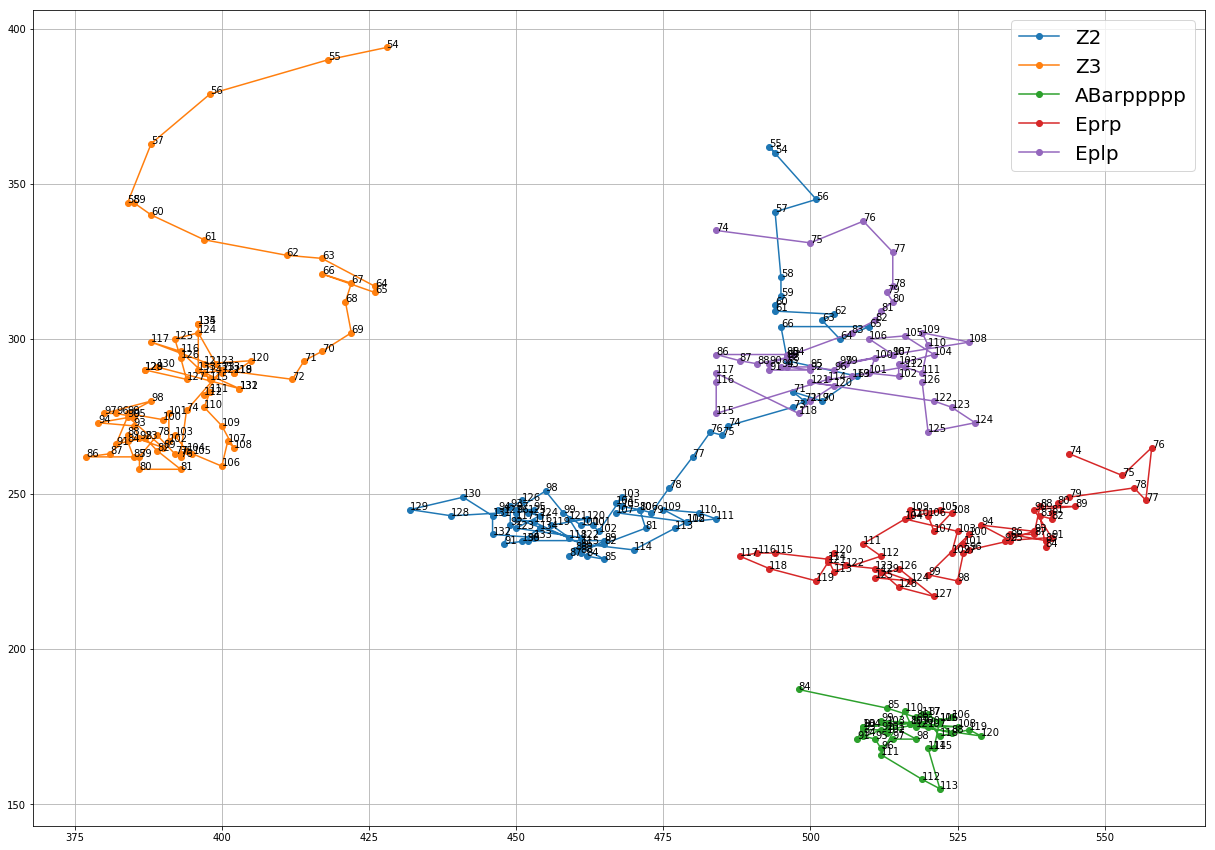

In [0]:
trace_movement_of_multiple_cells(cell_names_list = [
                                                    "Z2",
                                                    "Z3",  
                                                    "ABarppppp",
                                                    "Eprp",
                                                    "Eplp"
                                                ])

## Visualising the movements of the first 5 cells 

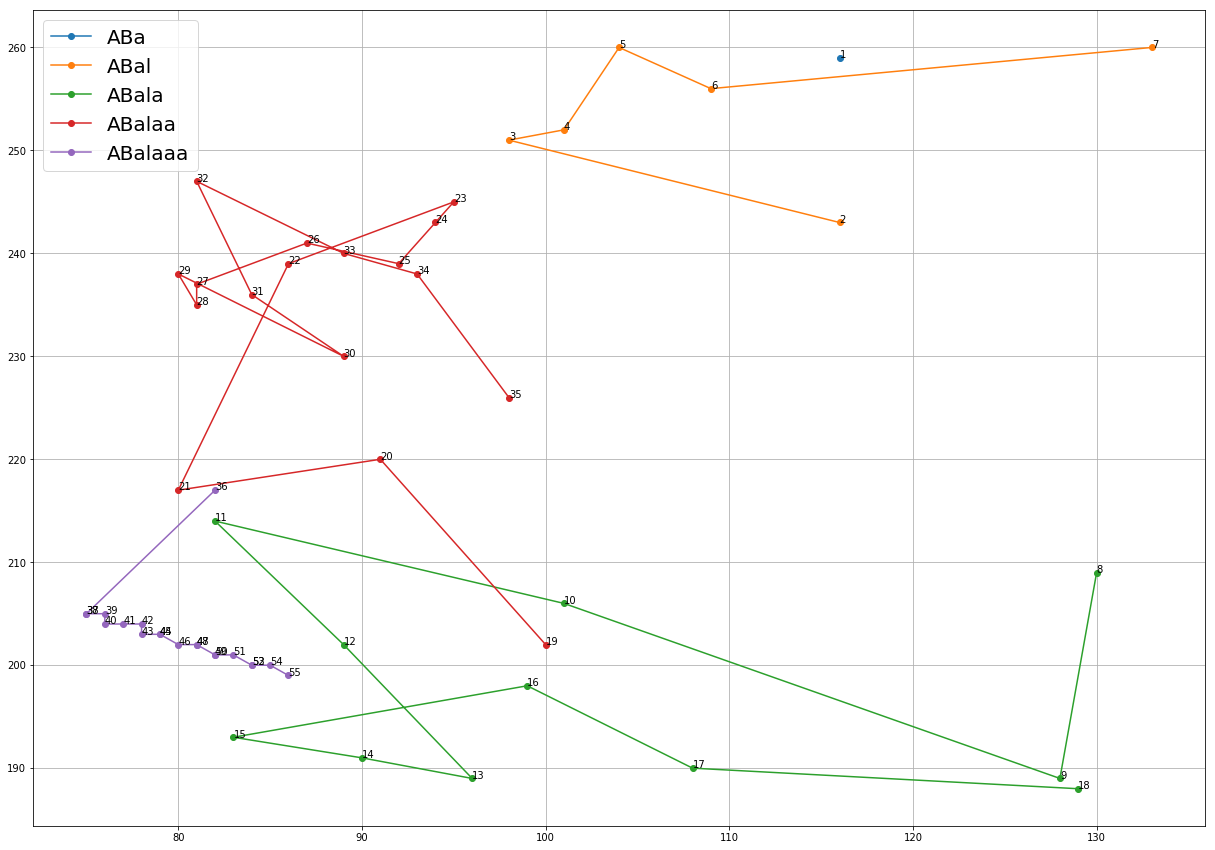

In [0]:
uniques = df["cell"].unique()
trace_movement_of_multiple_cells(cell_names_list = uniques[:5])


## Scaling up to download all the data from the website 

In [0]:
!pip install wget
import wget

In [0]:
url = "http://epic.gs.washington.edu/downloads/zipped_CD_Files.zip"
filename = wget.download(url)
print(filename)

zipped_CD_Files.zip


In [0]:
try:
    os.mkdir("storage")
except:
    shutil.rmtree("storage")
    os.mkdir("storage")

!unzip zipped_CD_Files.zip -d /content/storage

In [0]:
def check(string, sub_str): 
    if (string.find(sub_str) == -1): 
        return False 
    else: 
        return True

csv_filenames_old =  os.listdir("storage")
csv_filenames = []

worm_strain = "unc"

for i in csv_filenames_old:
    if check(i, worm_strain) == True:
        csv_filenames.append(i)

['CD20091119_unc-130_9E1_4_L1.csv', 'CD20089219_unc-130_9E1_8_L2.csv']

In [0]:
required_columns = ["cell", "time", "x", "y", "compact_cellname"]

In [0]:
def generate_compact_cellnames(cellname_column_values):
    c = []

    for i in cellname_column_values:
        short = i[:3]
        c.append(short)
    return c 

def select_columns(df, column_names_list):
    ret = df[column_names_list].copy()
    del df
    return ret

def generate_labels(df , column_name):

    labels =  df[column_name].astype("category").cat.codes.values
    return labels


In [0]:
def generate_train_df(filename, return_columns):
    test_df = pd.read_csv(filename)
    test_df["compact_cellname"] = generate_compact_cellnames(test_df["cell"].values)
    test_df = select_columns(test_df, return_columns )

    return test_df


In [0]:
def generate_final_data(csv_foldername, num_files , required_columns, savename = "save.csv"):
    dfs = []
    for i in tqdm(os.listdir(csv_foldername)[:num_files]):
        filename = csv_foldername + "/" + i

        df = generate_train_df(filename, required_columns)
        dfs.append(df)
    final = pd.concat(dfs)
    final["label"] = generate_labels(final, "compact_cellname")

    final.to_csv(savename, index= False)
    print("saved at : ", savename)
    

In [0]:
required_columns = ["cell", "time", "x", "y", "size", "compact_cellname"]

generate_final_data(csv_foldername = "storage", 
                    num_files = 2,
                    required_columns= required_columns,
                    savename = ROOT + "data/unc_training_data.csv")

100%|██████████| 2/2 [00:00<00:00, 12.02it/s]


saved at :  /content/drive/My Drive/data/unc_training_data.csv


In [0]:
df = pd.read_csv( ROOT + "data/unc_training_data.csv")
print("shape = ", df.shape)
df.head()

shape =  (64320, 7)


,cell,time,x,y,size,compact_cellname,label
0,ABa,1,227,280,80,ABa,0
1,ABa,2,221,262,80,ABa,0
2,ABa,3,192,239,84,ABa,0
3,ABa,4,168,242,88,ABa,0
4,ABa,5,162,267,92,ABa,0
